# Mini-Beispiel für CNN mit PyTorch

In [53]:
# train_cnn.py
import os
from pathlib import Path

import numpy as np
from PIL import Image

import torch
from torch import nn
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms

import time

def _sync_cuda():
    if torch.cuda.is_available():
        torch.cuda.synchronize()


def rgb_loader(path):
    with open(path, "rb") as f:
        img = Image.open(f)
        # Sonderfall: Palettenbild mit Transparenz als Bytes -> erst RGBA
        if img.mode == "P" and "transparency" in img.info and isinstance(img.info["transparency"], (bytes, bytearray)):
            img = img.convert("RGBA").convert("RGB")
        else:
            img = img.convert("RGB")
        return img
    

def get_loaders(root, img_size=224, batch_size=32, val_split=0.2, seed=42, num_workers=1):
    root = Path(root)

    # Transforms: leichte Augmentierung für Training, nur Resize+Norm fürs Validieren
    mean = [0.485, 0.456, 0.406]
    std  = [0.229, 0.224, 0.225]

    train_tfms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

    val_tfms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

    # Zwei ImageFolder-Instanzen auf das gleiche Root, aber mit unterschiedlichen Transforms
    train_dataset = datasets.ImageFolder(root=str(root), transform=train_tfms, loader=rgb_loader)
    val_dataset   = datasets.ImageFolder(root=str(root), transform=val_tfms, loader=rgb_loader)

    # Reproduzierbarer Index-Split
    num_samples = len(train_dataset)
    print(f"{num_samples=}")
    indices = np.arange(num_samples)
    rng = np.random.default_rng(seed)
    rng.shuffle(indices)

    split = int(np.floor(val_split * num_samples))
    val_idx = indices[:split]
    train_idx = indices[split:]

    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler   = SubsetRandomSampler(val_idx)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler,
                              num_workers=num_workers, pin_memory=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler,
                              num_workers=num_workers, pin_memory=True)
    return train_loader, val_loader, train_dataset.classes

class SimpleCNN(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        # Kleines, effizientes CNN
      

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1)),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
        

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    correct, total, running_loss = 0, 0, 0.0
    criterion = nn.CrossEntropyLoss()
    for imgs, labels in loader:
        imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss / total, correct / total

def train(root="data", epochs=10, img_size=224, batch_size=32, lr=1e-3, val_split=0.2, seed=42):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")

    train_loader, val_loader, classes = get_loaders(
        root=root, img_size=img_size, batch_size=batch_size, val_split=val_split, seed=seed
    )
    num_classes = len(classes)
    print(f"Klassen ({num_classes}): {classes}")

    model = SimpleCNN(num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()

    best_val_acc = 0.0
    best_path = "best_cnn.pth"

    total_start = time.perf_counter()

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss, running_correct, running_total = 0.0, 0, 0

        # ---- TRAINING ZEITMESSUNG ----
        _sync_cuda()
        train_start = time.perf_counter()

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(1)
            running_correct += (preds == labels).sum().item()
            running_total += labels.size(0)

        _sync_cuda()
        train_time = time.perf_counter() - train_start
        # --------------------------------

        train_loss = running_loss / running_total
        train_acc = running_correct / running_total

        # ---- EVAL ZEITMESSUNG ----
        model.eval()
        _sync_cuda()
        eval_start = time.perf_counter()

        val_loss, val_acc = evaluate(model, val_loader, device)

        _sync_cuda()
        eval_time = time.perf_counter() - eval_start
        # ---------------------------

        print(
            f"Epoch {epoch:02d}/{epochs} | "
            f"Train Loss: {train_loss:.4f} Acc: {train_acc:.3f} | "
            f"Val  Loss: {val_loss:.4f} Acc: {val_acc:.3f} | "
            f"Times: Train {train_time:.2f}s, Eval {eval_time:.2f}s"
        )

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({"model_state": model.state_dict(),
                        "classes": classes,
                        "img_size": img_size}, best_path)
            print(f"✓ Bestes Modell aktualisiert: {best_path} (Val Acc {best_val_acc:.3f})")

    _sync_cuda()
    total_time = time.perf_counter() - total_start
    print("Training fertig.")
    print(f"Bestes Val-Accuracy: {best_val_acc:.3f}")
    print(f"Gesamtzeit: {total_time/60:.2f} min")

    return model


if __name__ == "__main__":
    # Passe 'root' an deinen Datenordner an:
    # Struktur: root/
    #   ├── klasse_a/
    #   │     ├── img1.jpg
    #   │     └── ...
    #   └── klasse_b/
    #         └── ...
    dataset_root = "/home/juebrauer/link_to_vcd/10_datasets/57_vehicle_image_classification/Vehicles"
    model = train(  root=dataset_root,
                    epochs=1,
                    img_size=224,
                    batch_size=32,
                    lr=1e-3,
                    val_split=0.2,
                    seed=42)


Device: cuda
num_samples=5589
Klassen (7): ['Auto Rickshaws', 'Bikes', 'Cars', 'Motorcycles', 'Planes', 'Ships', 'Trains']
Epoch 01/1 | Train Loss: 1.3580 Acc: 0.504 | Val  Loss: 1.1256 Acc: 0.579 | Times: Train 37.26s, Eval 7.78s
✓ Bestes Modell aktualisiert: best_cnn.pth (Val Acc 0.579)
Training fertig.
Bestes Val-Accuracy: 0.579
Gesamtzeit: 0.75 min


# Qualitative Evaluierung

Gespeichert unter: /media/veracrypt1/09_src/code_jb/0017_semester_code_dl4cv/predictions_5x5.png


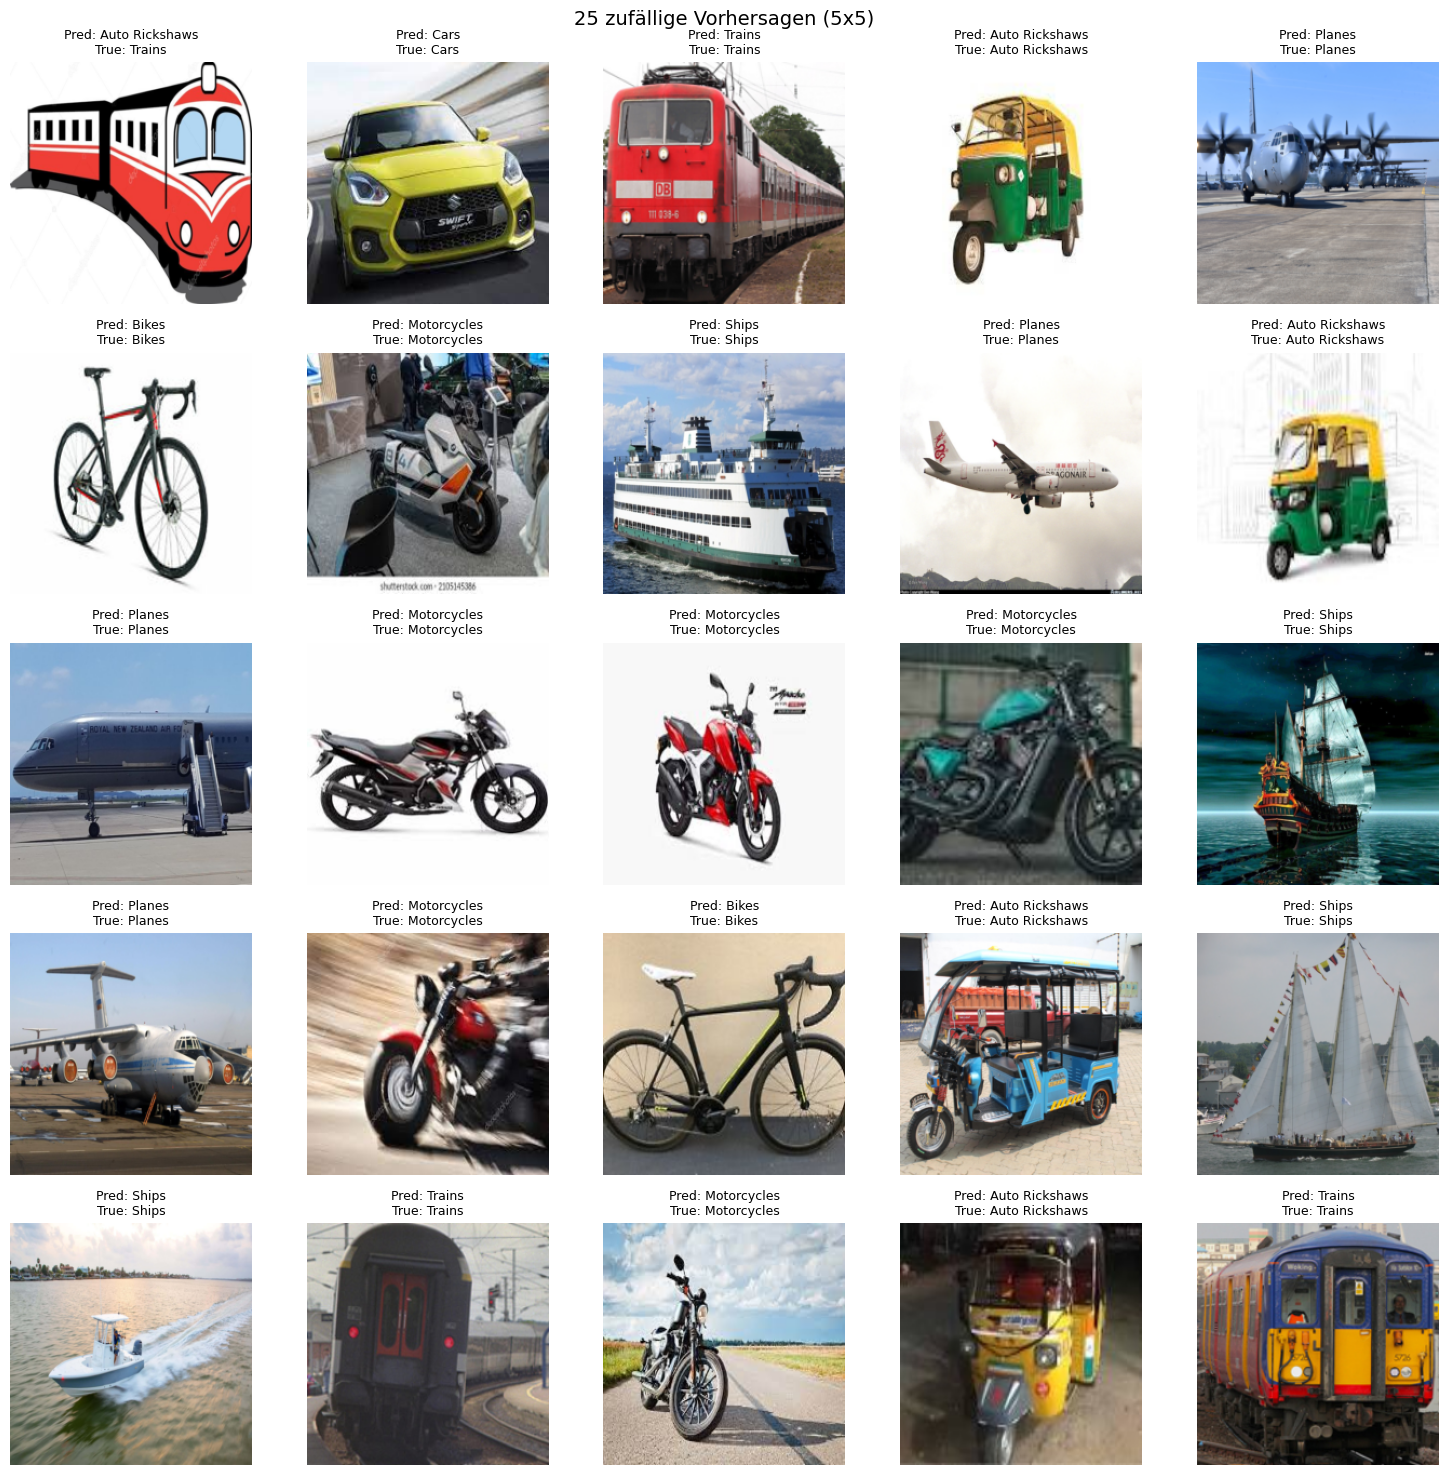

In [1]:
# viz_25_samples.py
from pathlib import Path
import random
import torch
from torch import nn
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt

# --- SimpleCNN (wie im Trainingsskript) -------------------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
# -----------------------------------------------------------

dataset_folder = "/home/juebrauer/link_to_vcd/10_datasets/57_vehicle_image_classification/Vehicles"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Checkpoint laden (enthält img_size & Klassen)
ckpt = torch.load("best_cnn.pth", map_location="cpu")
classes = ckpt["classes"]
img_size = ckpt["img_size"]

# Transforms: fürs Inferenz-Input (wie Validation)
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
infer_tfms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# Fürs Anzeigen (ohne Norm, gleiche Größe)
display_tfms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
])

# Dataset (liest Dateipfade & Targets)
ds = datasets.ImageFolder(root=dataset_folder)

# Modell wiederherstellen
model = SimpleCNN(num_classes=len(classes))
model.load_state_dict(ckpt["model_state"])
model.to(device).eval()

# 25 (oder weniger) zufällige Indizes ziehen
n = min(25, len(ds))
indices = random.sample(range(len(ds)), n)

# Vorbereiten der Figur 5x5
rows, cols = 5, 5
fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
axes = axes.flatten()

# Durch zufällige Bilder iterieren
with torch.no_grad():
    for i, idx in enumerate(indices):
        path, true_label = ds.samples[idx]  # (Pfad, Klassenindex)
        # Bild fürs Modell
        img_in = infer_tfms(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
        logits = model(img_in)
        pred_idx = logits.argmax(1).item()
        pred_name = classes[pred_idx]

        # Bild fürs Anzeigen
        disp_img = display_tfms(Image.open(path).convert("RGB"))
        ax = axes[i]
        ax.imshow(disp_img)
        # Titel mit Vorhersage (und wahrem Label)
        title = f"Pred: {pred_name}\nTrue: {classes[true_label]}"
        ax.set_title(title, fontsize=9)
        ax.axis("off")

    # Leere Achsen ausblenden, falls < 25 Bilder
    for j in range(i+1, rows*cols):
        axes[j].axis("off")

fig.suptitle("25 zufällige Vorhersagen (5x5)", fontsize=14)
plt.tight_layout()
out_path = Path("predictions_5x5.png")
plt.savefig(out_path, dpi=150)
print(f"Gespeichert unter: {out_path.resolve()}")
plt.show()

# Die PyTorch `dataset` und `DataLoader` Klasse

0
torch.Size([32, 3, 224, 224])
torch.Size([32])
tensor([2, 4, 3, 2, 2, 3, 6, 0, 0, 0, 1, 3, 3, 5, 1, 4, 2, 1, 1, 4, 1, 5, 4, 1,
        4, 3, 4, 6, 2, 2, 5, 6])


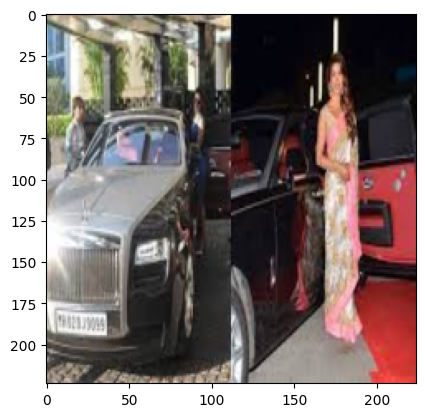

In [38]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        #transforms.Normalize(mean, std),
])

dataset_folder = "/home/juebrauer/link_to_vcd/10_datasets/57_vehicle_image_classification/Vehicles"
train_dataset = datasets.ImageFolder(root=dataset_folder,
                                     transform=train_tfms) 

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

for batch_nr, (imgs, labels) in enumerate(train_loader):
    print(batch_nr)
    print(imgs.shape)
    print(labels.shape)

    print(labels)

    first_img_of_first_batch = imgs[0].permute(1,2,0)
    
    if True:
        plt.imshow(first_img_of_first_batch)
        plt.show()
        break

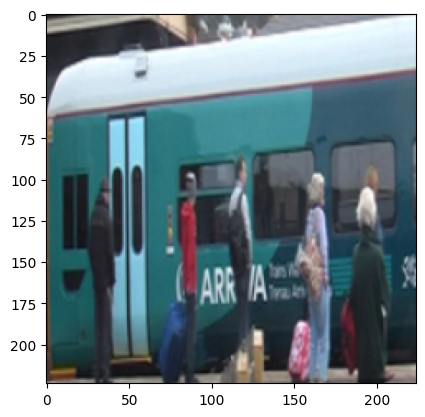

In [37]:
first_img_of_first_batch = imgs[-1].permute(1,2,0)
    
plt.imshow(first_img_of_first_batch)
plt.show()

In [34]:
len(train_dataset)

5589

In [35]:
5589 / 128

43.6640625

In [33]:
len(train_loader)

44

In [3]:
type(train_dataset)

torchvision.datasets.folder.ImageFolder

In [4]:
train_dataset.classes

['Auto Rickshaws', 'Bikes', 'Cars', 'Motorcycles', 'Planes', 'Ships', 'Trains']

In [5]:
train_dataset.class_to_idx

{'Auto Rickshaws': 0,
 'Bikes': 1,
 'Cars': 2,
 'Motorcycles': 3,
 'Planes': 4,
 'Ships': 5,
 'Trains': 6}

In [6]:
train_dataset.class_to_idx["Motorcycles"]

3

In [8]:
len(train_dataset.targets)

5589

In [11]:
train_dataset.samples[2000:2005]

[('/home/juebrauer/link_to_vcd/10_datasets/57_vehicle_image_classification/Vehicles/Cars/Car (462).jpg',
  2),
 ('/home/juebrauer/link_to_vcd/10_datasets/57_vehicle_image_classification/Vehicles/Cars/Car (463).jpg',
  2),
 ('/home/juebrauer/link_to_vcd/10_datasets/57_vehicle_image_classification/Vehicles/Cars/Car (464).jpg',
  2),
 ('/home/juebrauer/link_to_vcd/10_datasets/57_vehicle_image_classification/Vehicles/Cars/Car (465).jpg',
  2),
 ('/home/juebrauer/link_to_vcd/10_datasets/57_vehicle_image_classification/Vehicles/Cars/Car (466).jpg',
  2)]

# Anzahl der Parameter unseres CNNs bestimmen

In [54]:
model

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, af

In [68]:
total_nr_params = 0
for name, param in model.named_parameters():
    nr_params = param.shape.numel()
    print(f"{name} --> {nr_params}")
    total_nr_params += nr_params

print("-"*50)
print(total_nr_params)

features.0.weight --> 864
features.0.bias --> 32
features.1.weight --> 32
features.1.bias --> 32
features.4.weight --> 18432
features.4.bias --> 64
features.5.weight --> 64
features.5.bias --> 64
features.8.weight --> 73728
features.8.bias --> 128
features.9.weight --> 128
features.9.bias --> 128
features.12.weight --> 294912
features.12.bias --> 256
features.13.weight --> 256
features.13.bias --> 256
classifier.2.weight --> 1792
classifier.2.bias --> 7
--------------------------------------------------
391175


In [69]:
100 * total_nr_params / 60e6

0.6519583333333333